In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import TextClassificationPipeline
from tqdm import tqdm
import torch
import pickle

# NOTAM Text Classification with BERT
This notebook explores classifying NOTAM data using the BERT model. It uses airport_notams.xls as its data source, which is a compilation of 6897 NOTAMs from the 10 US airports with the highest traffic. The NOTAMs from each individual airport were retreived from the official [FAA website](https://notams.aim.faa.gov/notamSearch/nsapp.html#/) using the 100 mile location filter.

The BERT classifier is a pretrained model from the transformers library. It is trained with early stopping patience 1, a batch size of 10, and 50 epochs. Invalid NOTAMs are filtered out prior to training, and the valid data uses an 80-10-10 split for training, testing, and validation data. This notebook saves the BERT tokenizer as a file called _tokenizer.pickle_ and the BERT model in a directory called _model/_.

In [229]:
# Helper functions

# Returns average, minimum, and maximum lengths of text
def get_lengths(data):
    avg_len, min_len, max_len = 0, np.inf, -1
    for example in data:
        length = len(example)
        avg_len += length
        if length < min_len:
            min_len = length
        if length > max_len:
            max_len = length
    avg_len /= len(data)
    return avg_len, min_len, max_len

# Creates a pie chart of the distribution of labels
def plot_distribution(data):
    counts = {}
    for example in data:
        if example in counts:
            counts[example] += 1
        else:
            counts[example] = 1
    plt.pie(counts.values(), labels=counts.keys())
    plt.show()

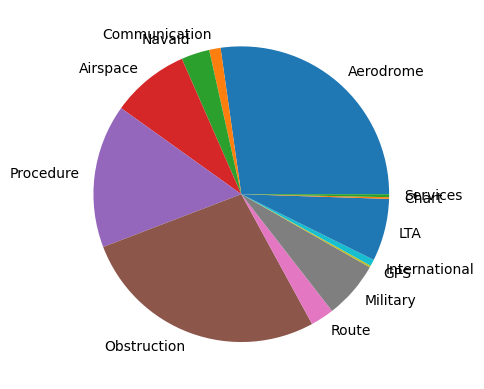

Average length: 192.40572571956287 
Min length: 14 
Max length: 13468


In [235]:
df = pd.read_excel("./airport_notams.xls")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

plot_distribution(df["Class"])

# Encoding for BERT
le = LabelEncoder()
text = df["NOTAM Condition/LTA subject/Construction graphic title"].map(str).values.tolist()
labels = le.fit_transform(df["Class"].values.tolist()).tolist()

lengths = get_lengths(text)
print(f"Average length: {lengths[0]} \nMin length: {lengths[1]} \nMax length: {lengths[2]}")

In [236]:
VALIDATION_SPLIT = 0.2
valid_keywords = ["RWY", "TWY", "APRON", "AD", "OBST", "NAV", "COM", "SVC", "AIRSPACE"]
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Wrapper class for dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val
                in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
# Return model for a specific number of classes
def get_model(num_labels):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

# Return batch tokenizer
def get_batch_tokenizer(tokenizer, dataset):
    return tokenizer.batch_encode_plus(dataset,
                                       max_length=256,
                                       padding=True,
                                       truncation=True,
                                       add_special_tokens=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')

# Normalize text
def normalize_text(text, labels):
    filtered = []
    filtered_labels = []
    text = [t.replace("\n", " ") for t in text]
    for i, t in enumerate(text):
        if not re.match("![a-zA-Z]* [0-9]*/[0-9]*", t[:11]):
            continue
        for v in valid_keywords:
            if v in t:
                filtered.append("".join([t for t in t.lower() if t.isalnum() or t == " "]))
                filtered_labels.append(labels[i])
                break
    return filtered, filtered_labels
    

# Split data function specific to BERT
def split_data(tokenizer, text, labels, test_size=VALIDATION_SPLIT):
    x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=test_size, stratify=labels, random_state=42)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

    x_train_tokens = get_batch_tokenizer(tokenizer, x_train)
    x_test_tokens = get_batch_tokenizer(tokenizer, x_test)
    x_valid_tokens = get_batch_tokenizer(tokenizer, x_valid)

    train_dataset = Dataset(x_train_tokens, y_train)
    test_dataset = Dataset(x_test_tokens, y_test)
    valid_dataset = Dataset(x_valid_tokens, y_valid)
    
    return train_dataset, test_dataset, valid_dataset

# Compute accuracy score as metric
def compute_metrics(p):
    prediction, labels = p
    preds_flat = np.argmax(prediction, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = accuracy_score(labels_flat, preds_flat)
    return {"eval_accuracy": accuracy}

# Train dataset
def train(train_dataset, valid_dataset, model, compute_metrics=compute_metrics):
    args = TrainingArguments(output_dir="output",
                             evaluation_strategy="epoch",
                             metric_for_best_model="eval_accuracy",
                             save_strategy="epoch",
                             num_train_epochs=50,
                             per_device_train_batch_size=10,
                             per_device_eval_batch_size=10,
                             load_best_model_at_end=True
                            )
    trainer = Trainer(args=args,
                        model=model,
                        train_dataset=train_dataset,
                        eval_dataset=valid_dataset,
                        compute_metrics=compute_metrics,
                        callbacks=[EarlyStoppingCallback(
                                early_stopping_patience=1)]
                        )
    trainer.train()
    return trainer

# Predict class
def predict_bert(tokenizer, text, model, encoding):
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    probabilities = sorted(pipe(text, top_k=None), key=lambda d: d["label"])
    prediction = np.argmax([x["score"] for x in probabilities])
    return f'{encoding[prediction]} with score {probabilities[prediction]["score"]*100}%'

loading file vocab.txt from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

In [237]:
text, labels = normalize_text(text, labels)
train_dataset, test_dataset, valid_dataset = split_data(bert_tokenizer, text, labels)
model = get_model(num_labels=13)
trainer = train(train_dataset, valid_dataset, model)
trainer.save_model('model')
with open(f'tokenizer.pickle', 'wb') as handle:
    pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
  

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.086830,0.977695
2,0.265600,0.032515,0.990706
3,0.064200,0.022724,0.996283
4,0.026200,0.027748,0.996283


***** Running Evaluation *****
  Num examples = 538
  Batch size = 10
Saving model checkpoint to output/checkpoint-431
Configuration saved in output/checkpoint-431/config.json
Model weights saved in output/checkpoint-431/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_6909/3726949273.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val
***** Running Evaluation *****
  Num examples = 538
  Batch size = 10
Saving model checkpoint to output/checkpoint-862
Configuration saved in output/checkpoint-862/config.json
Model weights saved in output/checkpoint-862/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_6909/3726949273.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [238]:
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1).flatten()
true_vals = predictions.label_ids
num_correct = 0
for i in range(len(preds)):
    if preds[i] == true_vals[i]:
        num_correct += 1
print(f"{float(num_correct) / len(preds) * 100}%")

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 538
  Batch size = 8
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_6909/3726949273.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val


98.88475836431226%


In [245]:
encoding = le.classes_
example_text = ["!LAX 04/004 LAX AIRSPACE UAS WI AN AREA DEFINED AS 2.5NM RADIUS OF 335111N1182242W (3.5NM NW TOA) SFC-400FT AGL 2304011905-2305012359"]
example_label = ["Aerodrome"]
normalized_example = normalize_text(example_text, example_label)
if len(normalized_example[0]) == 0:
    print("Invalid NOTAM")
else:
    print(predict_bert(bert_tokenizer, normalized_example[0][0], model, encoding))

Airspace with score 99.90589022636414%
